In [103]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh
%matplotlib widget

In [104]:
def parametric_hail_model(w, l, params):
    """
    inputs:
    w: float
        varies from 0 to 2*pi
    l: float
        varies from -0.5*pi to 0.5*pi
    params: dict containing the following keys
        p: float
            shape parameter 1
        r: float
            shape parameter 2
        s: float
            shape parameter 3
        q: float
            shape parameter 4 (controls number of lobes)
    """
    p = params['p']
    r = params['r']
    s = params['s']
    q = params['q']
    x = np.cos(w)*np.cos(l)*(p * ((1 - (np.cos(q*w))**2)**r) * ((1 - (np.cos(q*l))**2)**r) + s)
    y = np.sin(w)*np.cos(l)*(p * ((1 - (np.cos(q*w))**2)**r) * ((1 - (np.cos(q*l))**2)**r) + s)
    z = np.sin(l) * (p * ((1 - (np.cos(q*w))**2)**r) * ((1 - (np.cos(q*l))**2)**r) + s)
    return x, y, z

In [151]:
def create_mesh_from_parametric(func, w_range, l_range, params, w_res, l_res):
    """
    Convert parametric surface to triangular mesh
    
    Parameters:
    func: function that takes (w, l) and returns (x, y, z)
    w_range: tuple (w_min, w_max)
    l_range: tuple (l_min, l_max)
    params: dict with parametric model parameters
    w_res, l_res: resolution for discretization
    """
    
    # Add extra points to close the surface
    w = np.linspace(w_range[0], w_range[1], w_res)
    l = np.linspace(l_range[0], l_range[1], l_res)
    
    W, L = np.meshgrid(w, l)
    X, Y, Z = func(W, L, params)
    
    # Create vertices array
    vertices = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
    
    # Create faces (triangles) from the grid
    faces = []
    for i in range(w_res - 1):
        for j in range(l_res - 1):
            # Each grid cell creates two triangles
            v1 = i * l_res + j
            v2 = i * l_res + (j + 1)
            v3 = (i + 1) * l_res + j
            v4 = (i + 1) * l_res + (j + 1)
            
            # First triangle
            faces.append([v1, v2, v3])
            # Second triangle
            faces.append([v2, v4, v3])
    
    faces = np.array(faces)
    
    return vertices, faces

def save_as_stl_trimesh(vertices, faces, filename):
    """Save mesh as STL using trimesh library (alternative method)"""
    # Create trimesh object
    mesh_obj = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    # Optional: fix mesh issues
    mesh_obj.update_faces(mesh_obj.unique_faces())
    mesh_obj.remove_unreferenced_vertices()
    
    # Save as STL
    mesh_obj.export(filename)
    print(f"STL file saved as: {filename}")

def visualize_surface(func, w_range, l_range, params, w_res, l_res):
    """Visualize the parametric surface"""
    w = np.linspace(w_range[0], w_range[1], w_res)
    l = np.linspace(l_range[0], l_range[1], l_res)
    W, L = np.meshgrid(w, l)
    X, Y, Z = func(W, L, params)

    print(np.shape(X))
    
    # This is the value that will be used for coloring
    distances = np.sqrt(X**2 + Y**2 + Z**2)
    # Normalize the distances to the range [0, 1] for the colormap
    norm_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=cm.viridis(norm_distances), alpha=1, cmap='viridis',
                        rcount=200,
                        ccount=200)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Parametric Surface')
    
    plt.show()

def check_mesh_quality(vertices, faces):
    """Check basic mesh quality metrics"""
    mesh_obj = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    print(f"Mesh quality report:")
    print(f"- Vertices: {len(vertices)}")
    print(f"- Faces: {len(faces)}")
    print(f"- Is watertight: {mesh_obj.is_watertight}")
    print(f"- Volume: {mesh_obj.volume:.4f}")
    print(f"- Surface area: {mesh_obj.area:.4f}")
    
    return mesh_obj

In [154]:
#set variables for model
w_range = (0, 2*np.pi)     # Range for parameter w
l_range = (-0.5*np.pi, 0.5*np.pi) # Range for parameter l
w_res = 100 #increase for a better model
l_res = 100 #increase for a better model
params = {'p': 1, 'r': 2, 's': 8,'q': 6} #short lobed example in table 1 of Wang et al. 2015 https://www.sciencedirect.com/science/article/pii/S016980951500071X

(100, 100)


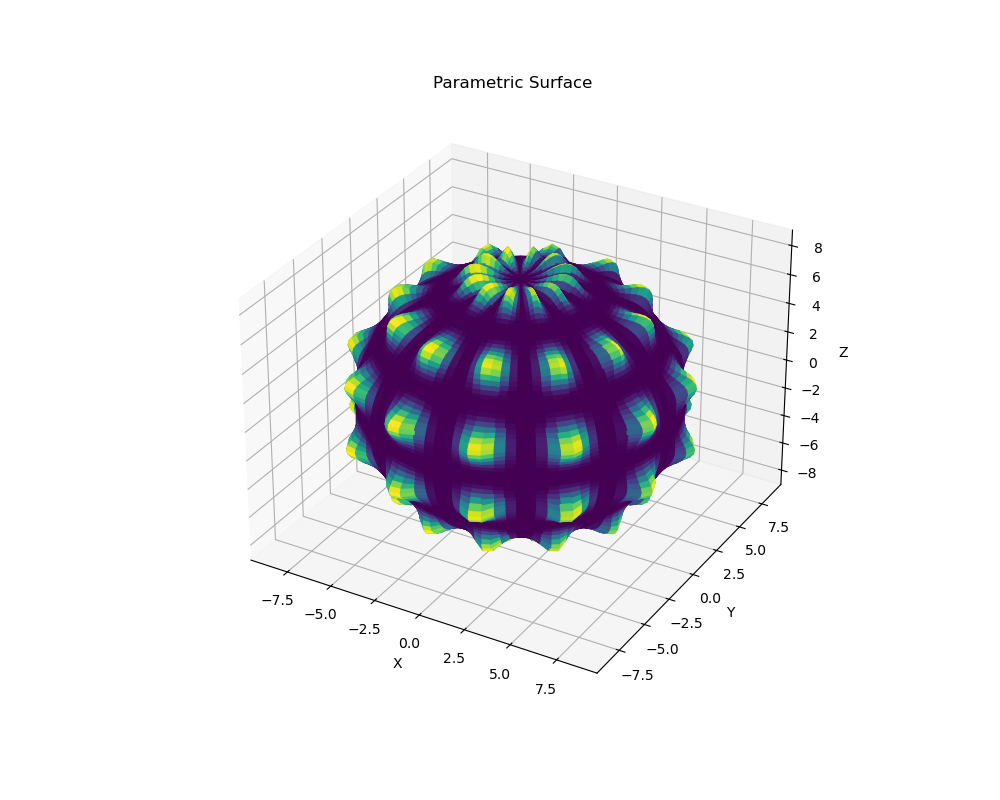

In [155]:
# visualise parametric model
# note, this will render at a reduced resolution by default (50 samples for each dimension)
visualize_surface(parametric_hail_model, w_range, l_range, params, w_res, l_res)

In [157]:
#create mesh from parametric model
vertices, faces = create_mesh_from_parametric(
    parametric_hail_model, 
    w_range, 
    l_range,
    params,
    w_res, 
    l_res
)

print(f"Mesh created with {len(vertices)} vertices and {len(faces)} faces")

check_mesh_quality(vertices, faces)

#save to stl file
save_as_stl_trimesh(vertices, faces, "parametric_hail_model.stl")

Mesh created with 10000 vertices and 19602 faces
Mesh quality report:
- Vertices: 10000
- Faces: 19602
- Is watertight: False
- Volume: 2263.4366
- Surface area: 948.0090
STL file saved as: parametric_hail_model.stl


In [ ]:
# visualise stl file

# Load the STL file
mesh = trimesh.load_mesh("parametric_hail_model.stl")
# Show the mesh (opens in a window)
mesh.show()